<a href="https://colab.research.google.com/github/anhkhoa039/CS114.K21.KHTN/blob/master/face_mask_correctly_last_2_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [59]:
!gdown --id 1j5B4h8ZP1npA5TlAr8DIHsHk85cd0CPV

Downloading...
From: https://drive.google.com/uc?id=1j5B4h8ZP1npA5TlAr8DIHsHk85cd0CPV
To: /content/train.zip
15.8MB [00:00, 139MB/s]


In [60]:
!gdown --id 1VP31QRhsGbYxgrbSECvizVvImjtJpYAV

Downloading...
From: https://drive.google.com/uc?id=1VP31QRhsGbYxgrbSECvizVvImjtJpYAV
To: /content/test.zip
3.27MB [00:00, 51.8MB/s]


In [61]:
# !rm -rf face_mask_dataset
# !rm -rf test

In [62]:
!unzip test.zip

Archive:  test.zip
   creating: test/
   creating: test/correct/
  inflating: test/correct/0650.jpg   
  inflating: test/correct/0655.jpg   
  inflating: test/correct/0661.jpg   
  inflating: test/correct/0669.jpg   
  inflating: test/correct/0671.jpg   
  inflating: test/correct/0690.jpg   
  inflating: test/correct/0693.jpg   
  inflating: test/correct/0698.jpg   
  inflating: test/correct/0714.jpg   
  inflating: test/correct/0719.jpg   
  inflating: test/correct/0725.jpg   
  inflating: test/correct/0727.jpg   
  inflating: test/correct/0733.jpg   
  inflating: test/correct/0743.jpg   
  inflating: test/correct/0746.jpg   
  inflating: test/correct/0759.jpg   
  inflating: test/correct/0760.jpg   
  inflating: test/correct/0769.jpg   
  inflating: test/correct/0770.jpg   
  inflating: test/correct/0773.jpg   
   creating: test/incorrect/
  inflating: test/incorrect/aug_11.jpg  
  inflating: test/incorrect/aug_13.jpg  
  inflating: test/incorrect/aug_16.jpg  
  inflating: test/incor

In [63]:
!unzip train.zip

Archive:  train.zip
   creating: face_mask_dataset/
   creating: face_mask_dataset/correct/
  inflating: face_mask_dataset/correct/0003.jpg  
  inflating: face_mask_dataset/correct/0018.jpg  
  inflating: face_mask_dataset/correct/0027.jpg  
  inflating: face_mask_dataset/correct/0029.jpg  
  inflating: face_mask_dataset/correct/0037.jpg  
  inflating: face_mask_dataset/correct/0040.jpg  
  inflating: face_mask_dataset/correct/0043.jpg  
  inflating: face_mask_dataset/correct/0048.jpg  
  inflating: face_mask_dataset/correct/0055.jpg  
  inflating: face_mask_dataset/correct/0063.jpg  
  inflating: face_mask_dataset/correct/0066.jpg  
  inflating: face_mask_dataset/correct/0091.jpg  
  inflating: face_mask_dataset/correct/0097.png  
  inflating: face_mask_dataset/correct/0113.jpg  
  inflating: face_mask_dataset/correct/0116.png  
  inflating: face_mask_dataset/correct/0121.png  
  inflating: face_mask_dataset/correct/0125.jpeg  
  inflating: face_mask_dataset/correct/0127.jpg  
  infla

In [64]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import random
import torchvision.transforms as transforms
import imageio

import glob
from PIL import Image
import cv2
import torch.nn as nn
from sklearn import svm
from torch.hub import load_state_dict_from_url
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Visualize dataset


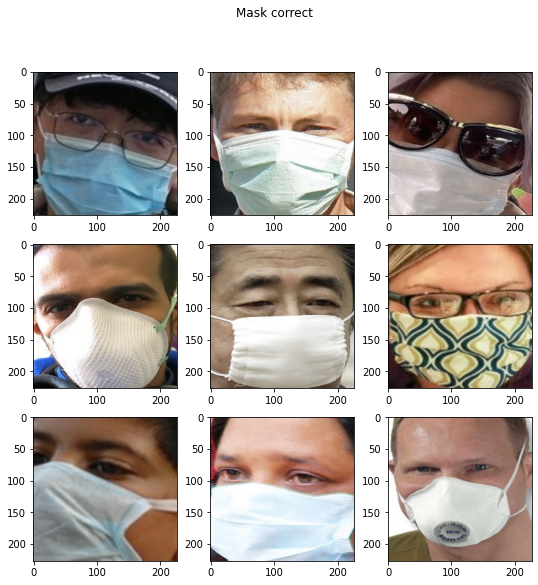

In [65]:
from matplotlib import pyplot as plt

root = 'face_mask_dataset'
img_paths = []
folder_path = glob.glob(root+'/*')
for label_path in folder_path:
  img_paths.extend(glob.glob(label_path+'/*'))

fig = plt.figure(figsize=(9, 9))
fig.suptitle('Mask correct')
for i, img_path in enumerate(img_paths[:9]):
    # define subplot
    fig.add_subplot(3, 3, i + 1)
    # plot raw pixel data
    img = cv2.imread(img_path)
    # img = np.resize(img, (227, 227, 3))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
 
# show the figure
plt.show()

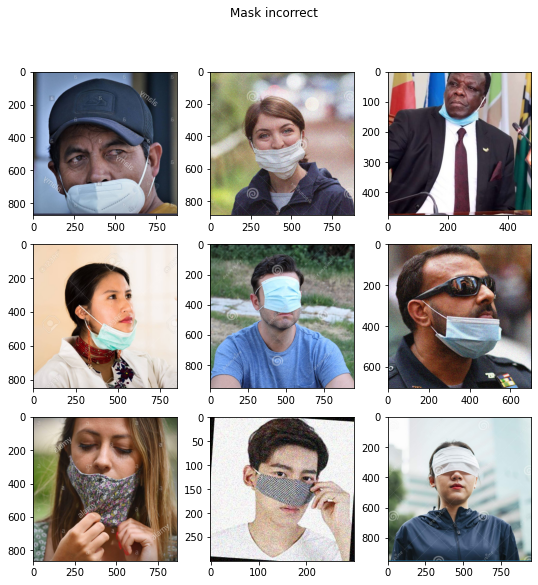

In [66]:
from matplotlib import pyplot as plt

root = 'face_mask_dataset'
img_paths = []
img_paths.extend(glob.glob(root+'/incorrect/*'))

fig = plt.figure(figsize=(9, 9))
fig.suptitle('Mask incorrect')
for i, img_path in enumerate(img_paths[9:18]):
    # define subplot
    fig.add_subplot(3, 3, i + 1)
    # plot raw pixel data
    img = cv2.imread(img_path)
    # img = np.resize(img, (227, 227, 3))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
 
# show the figure
plt.show()

# Create dataloader

In [67]:
class FM_Dataset(TensorDataset):
    def __init__(self, root):
        super(FM_Dataset, self).__init__()
        self.root = root
        self.labels = []
        self.img_paths = []
        self.transform =  transforms.Compose([
          transforms.ToPILImage(),
          transforms.ToTensor()])

        folder_path = glob.glob(root+'/*')
        for label_path in folder_path:
          self.img_paths.extend(glob.glob(label_path+'/*'))
        
        # print(self.img_paths[0])
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = cv2.imread(img_path)
        img = np.resize(img, (227, 227, 3))
        img = self.transform(img)

        label = img_path.split('/')[-2]
        if label == 'incorrect':
          label = 0
        else:
          label = 1

        return img, label


    def __len__(self):
        return len(self.img_paths) 

# Initialize dataloader

In [68]:
train_dataset = FM_Dataset('face_mask_dataset')
trainset_loader = DataLoader(train_dataset,
                                 shuffle=False,
                                 batch_size=4,
                                 pin_memory=True,
                                drop_last=True
                                 )

# Download VGG19 pretrained

In [69]:
import torchvision.models as models

VGG19_model = models.vgg19(pretrained=True)

for param in VGG19_model.parameters():
    param.requires_grad = False
VGG19_model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Create 2 models 
- Model 1: Remove last FC
- Model 2: Remove 2 last FC

In [70]:
new_classifier = nn.Sequential(*list(VGG19_model.classifier.children())[:-2])
VGG19_model.classifier = new_classifier

# Features extraction from 2 these models

In [71]:
features = []
labels = []

# loop over the dataset multiple times
for i, data in enumerate(trainset_loader):
  img, label = data[0].cuda(), data[1].cuda()
  with torch.no_grad():
    output = VGG19_model(img)
    output = output.cpu()

    # if i == 0:
    #   print(img[0][0])
    #   print(output[0][0])
    features.extend(np.squeeze(output.data.numpy()))

    labels.extend(label.cpu().numpy())

print('Finished extracting features of VGG19')

Finished extracting features of VGG19


In [72]:
print(features[0])

[0. 0. 0. ... 0. 0. 0.]


In [73]:
print(np.shape(features))
print(np.shape(labels))

(160, 4096)
(160,)


### xxx

In [74]:
# features_1 = []
# features_2 = []
# labels = []

# for epoch in range(1):  # loop over the dataset multiple times
#     for _, data in enumerate(trainset_loader):
#         img, label = data[0].cuda(), data[1].cuda()

#         output_1 = AlexNet_model_1(img)
#         output_1 = output_1.cpu()
#         features_1.extend(np.squeeze(output_1.data.numpy()))

#         output_2 = AlexNet_model_2(img)
#         output_2 = output_2.cpu()
#         features_2.extend(np.squeeze(output_2.data.numpy()))
        
#         labels.extend(label.cpu().numpy())

# print('Finished extracting features of AlexNet')

In [75]:
# #Updating the second classifier
# AlexNet_model.classifier[4] = nn.Linear(4096,4096)

# #Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
# AlexNet_model.classifier[6] = nn.Linear(1024,10)

In [76]:
print(np.shape(features))
print(np.shape(labels))

(160, 4096)
(160,)


## Create SVM model and train with 2 feature-map (80% training - 20% testing)

In [77]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(features, labels)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [78]:
# clf_1 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf_1.fit(features_1, labels)

# clf_2 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf_2.fit(features_2, labels)

# Compare accuracy between 2 models

In [79]:
test_dataset = FM_Dataset('test')

In [80]:
testset_loader = DataLoader(test_dataset,
                                 shuffle=False,
                                 batch_size=1,
                                 pin_memory=True,
                                drop_last=True
                                 )

In [81]:
features_test = []
labels_test = []
 # loop over the dataset multiple times
for _, il in enumerate(testset_loader):
    image, label = il[0].cuda(), il[1].cuda()

    output = VGG19_model(image)
    output = output.cpu()
    features_test.append(np.squeeze(output.data.numpy()))
    labels_test.append(label.cpu().numpy())

print('Finished extracting features of VGG19')

Finished extracting features of VGG19


In [82]:
print((features_test[0]))

[0.        0.        0.        ... 1.0253087 0.        0.7310671]


In [83]:
y_pre = clf.predict(features_test)

print(accuracy_score(y_pre, labels_test))

0.925


In [84]:
print(classification_report(labels_test, y_pre, target_names=['incorrect', 'correct']))

              precision    recall  f1-score   support

   incorrect       1.00      0.85      0.92        20
     correct       0.87      1.00      0.93        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



# Confusion matrix of model over 40 samples (20% testing) 

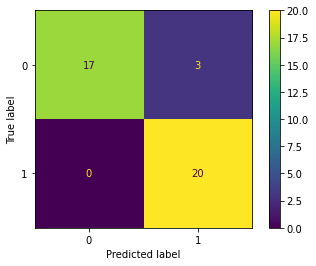

In [85]:
plot_confusion_matrix(clf, features_test, labels_test)
plt.show() 

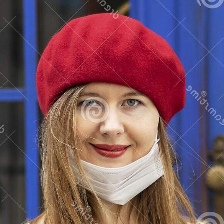


Wear mask incorrectly


In [87]:
from PIL import Image
from torch.autograd import Variable
from google.colab.patches import cv2_imshow

img_path = '/content/test/incorrect/aug_11.jpg'

img_pre = cv2.imread(img_path)
img = np.resize(img_pre, (224, 224, 3))

preprocess = transforms.Compose([
       transforms.ToPILImage(),
       transforms.ToTensor()
    ])
img_tensor = preprocess(img)
img_tensor.unsqueeze_(0)
img_var = Variable(img_tensor)
img_var = img_var.cuda()
out = VGG19_model(img_var)

newOut = np.squeeze(out)
newOut = newOut.cpu()

newOut = torch.unsqueeze(newOut, 0)
pred = clf.predict(newOut.data.numpy())
cv2_imshow(cv2.resize(img_pre, (224, 224)))
if pred == 1:
  print('\nWear mask correctly')
else:
  print('\nWear mask incorrectly')